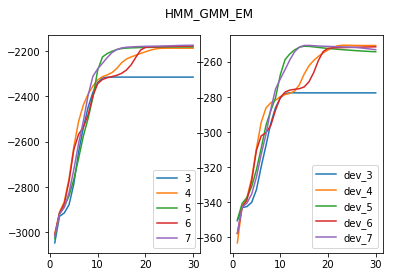

In [130]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
def forward_backward(transMatrix, b_Gaussian,pi,K):
    N=len(b_Gaussian)
    alpha=np.zeros((N,K))
    beta=np.zeros((N,K))
    alpha_list=[]
    alpha[0,:]=np.multiply(pi,b_Gaussian[0,:])
    alpha_list.append(1/np.sum(alpha[0,:]))
    alpha[0,:]=alpha[0,:]/np.sum(alpha[0,:])
    beta[N-1,:]=[1 for k in range(K)]
    beta_list=[]
    ##FORWARD
    for t in range(1,N):
        for j in range(K):
            temp=0
            for i in range(K):
                temp=temp+alpha[t-1,i]*transMatrix[i,j]
            alpha[t,j]=temp*b_Gaussian[t,j]
        alpha_list.append(1/np.sum(alpha[t,:]))
        alpha[t,:]=alpha[t,:]/np.sum(alpha[t,:])

    ##BACKWARD
    for t in range(N-2,-1,-1):
        for i in range(K):
            temp=0
            for j in range(K):
                temp=temp+transMatrix[i,j]*b_Gaussian[t+1,j]*beta[t+1,j]
            beta[t,i]=temp
        #print(beta[t,:])
        beta[t,:]=beta[t,:]*alpha_list[t]
        #print(beta[t,:])
    
    return alpha,beta,alpha_list,beta_list

def cal_Gamma(gamma,alpha,beta):
    for t in range(len(gamma)):
        denominator=np.sum(np.multiply(alpha[t,:],beta[t,:]))
        temp=np.multiply(alpha[t,:],beta[t,:])
        gamma[t,:]=temp/denominator
    return gamma

def cal_Delta(delta,gamma,b_gaussian,beta,transMatrix,K):
    T=len(gamma)
    for t in range(T-1):
        for i in range(K):
            for j in range(K):
                delta[t,i,j]=(gamma[t,i]*transMatrix[i,j]*b_gaussian[t+1,j]*beta[t+1,j])/beta[t,i]
    return delta

def update_transMatrix(transMatrix,delta,gamma):
    K=len(transMatrix)
    T=len(gamma)
    for i in range(K):
        bottom=sum(gamma[t,i]for t in range(T-1))
        for j in range(K):
            up=sum(delta[t,i,j]for t in range(T-1))      
            transMatrix[i,j]=up/bottom
    for i in range(K):
        transMatrix[i,:]/=np.sum(transMatrix[i,:])
    return transMatrix

def cal_Gaussian(N,K,data,b_gaussian,mu,cov):
    for n in range(N):
        for k in range(K):
            b_gaussian[n,k]=Gaussian(data[n],mu[k],cov[k])
    return b_gaussian

def update_mu(N,K,mu,data,gamma):
    for i in range(K):
        up=0
        bottom=0
        for t in range(N):
            up=up+gamma[t,i]*data[t]
            bottom=bottom+gamma[t,i]
        mu[i]=up/bottom
    return mu

def update_cov(N,K,gamma,data,mu,cov):
    for i in range(K):
        up=0
        bottom=0
        for t in range(N):
            up=up+gamma[t,i]*np.outer((data[t,:])-mu[i,:],np.transpose(data[t,:]-mu[i,:]))
        bottom=np.sum(gamma[:,i])
        cov[i]=up/bottom
    return cov

def EM_HMM(K,data,dev_data,iterations):
    N=len(data)
    N_dev=len(dev_data)
    transMatrix=np.full((K,K),1/K) ##initialize trans Matrix with dimension K*K
    gamma=np.zeros((N,K))
    delta=np.zeros((N,K,K))##use this to reestimate the transition Matrix
    mu=np.zeros((K,2))
    a=np.mean(data[:,0] )
    b=np.mean(data[:,1])
    #kmeans=KMeans(n_clusters=K, random_state=0).fit(data)
    #mu=kmeans.cluster_centers_
    random_noise= np.random.rand(K,2)-0.5 
    for k in range(K):
        mu[k]=[a+random_noise[k,0],b+random_noise[k,1]]
    cov=np.zeros((K,2,2))
    cov[:,0,0]=1
    cov[:,1,1]=1
    logLL_List=[]
    b_gaussian=np.zeros((N,K))
    pi=np.full(K,1/K)
    output_dev=[]
    for iteration in range(iterations):
        ## E STEP
        for i in range(K):
            b_gaussian[:,i]=multivariate_normal.pdf(data,mu[i],cov[i])
        alpha,beta,alpha_list,_=forward_backward(transMatrix, b_gaussian,pi,K)
        gamma=cal_Gamma(gamma,alpha,beta)
        delta=cal_Delta(delta,gamma,b_gaussian,beta,transMatrix,K)
        
        ## evluate dev data
        logLL_Dev=0
        temp=np.zeros((N_dev,K))
        for i in range(K):
            temp[:,i]=multivariate_normal.pdf(dev_data,mu[i],cov[i])
        _,_,temp_list,_=forward_backward(transMatrix,temp,pi,K)
        log_dev=0
        for i in range(len(temp_list)):
            log_dev-=np.log(temp_list[i])
        output_dev.append(log_dev)
            
        
        ## M STEP
        pi=gamma[0] ##update pi
        transMatrix=update_transMatrix(transMatrix,delta,gamma)##update trans Matrix
        mu=update_mu(N,K,mu,data,gamma)
        cov=update_cov(N,K,gamma,data,mu,cov)
        
        ##evaluate log likelihood
        logC=0
        for i in range(len(alpha_list)):
            logC=logC+np.log(alpha_list[i])
        logLL=np.log(np.sum(alpha[-1,:]))-logC
        logLL_List.append(logLL)
    return logLL_List,output_dev
                                                                                                                                               

data=np.loadtxt('points.dat')
cut=int(len(data)*0.9)
train_data=data[:cut,:]
dev_data=data[cut:,:]
iteration=30
x_aixs = np.arange(1,iteration+1)
f,(ax1,ax2)=plt.subplots(1,2)
f.suptitle('HMM_GMM_EM')
log_list,develop=EM_HMM(3,train_data,dev_data,iteration)  
ax1.plot(x_aixs,log_list,label='3')
ax2.plot(x_aixs,develop,label='dev_3')
log_list,develop=EM_HMM(4,train_data,dev_data,iteration)  
ax1.plot(x_aixs,log_list,label='4')
ax2.plot(x_aixs,develop,label='dev_4')
log_list,develop=EM_HMM(5,train_data,dev_data,iteration)  
ax1.plot(x_aixs,log_list,label='5')
ax2.plot(x_aixs,develop,label='dev_5')
log_list,develop=EM_HMM(6,train_data,dev_data,iteration)  
ax1.plot(x_aixs,log_list,label='6')
ax2.plot(x_aixs,develop,label='dev_6')
log_list,develop=EM_HMM(7,train_data,dev_data,iteration)  
ax1.plot(x_aixs,log_list,label='7')
ax2.plot(x_aixs,develop,label='dev_7')
ax1.legend()
ax2.legend()
plt.show()

In [6]:
##back up 
import numpy as np
def Gaussian(data,mu,cov):
    det=np.linalg.det(cov)
    t=np.dot(np.transpose(data-mu),np.linalg.inv(cov))
    exp=np.exp(-0.5*np.dot(t,(data-mu)))
    gauss=1/(np.power(2*np.pi*np.sqrt(det),0.5))*exp
    return gauss

def forward_backward(transMatrix, b_Gaussian,pi,K):
    N=len(b_Gaussian)
    alpha=np.zeros((N,K))
    beta=np.zeros((N,K))
    alpha_list=[]
    alpha[0,:]=np.multiply(pi,b_Gaussian[0,:])
    alpha_list.append(1/np.sum(alpha[0,:]))
    alpha[0,:]=alpha[0,:]/np.sum(alpha[0,:])
    beta[N-1,:]=[1 for k in range(K)]
    beta_list=[]
    ##FORWARD
    for t in range(1,N):
        temp=np.zeros(K)
        for i in range(K):
            temp[i]=np.sum(np.multiply(alpha[t-1,:],transMatrix[i,:]))
        alpha[t,:]=np.multiply(temp,b_Gaussian[t,:])
        alpha_list.append(1/np.sum(alpha[t,:]))
        alpha[t,:]=alpha[t,:]/np.sum(alpha[t,:])

    ##BACKWARD
    for t in range(N-2,-1,-1):
        temp=np.zeros(K)
        for j in range(K):
            #print("for fun ",transMatrix[j,:],b_Gaussian[t+1,:],beta[t+1,:])
            temp[j]=np.sum(np.multiply(np.multiply(transMatrix[j,:],b_Gaussian[t+1,:]),beta[t+1,:]))
        beta[t,:]=temp
        #print(beta[t,:])
        beta[t,:]=beta[t,:]*alpha_list[t]
        #print(beta[t,:])
    
    return alpha,beta,alpha_list,beta_list

def cal_Gamma(gamma,alpha,beta):
    for t in range(len(gamma)):
        denominator=np.sum(np.multiply(alpha[t,:],beta[t,:]))
        temp=np.multiply(alpha[t,:],beta[t,:])
        gamma[t,:]=temp/denominator
    return gamma

def cal_Delta(delta,gamma,b_gaussian,beta,transMatrix,K):
    T=len(gamma)
    for t in range(T-1):
        for i in range(K):
            for j in range(K):
                delta[t,i,j]=(gamma[t,i]*transMatrix[i,j]*b_gaussian[t+1,j]*beta[t+1,j])/beta[t,i]
    return delta

def update_transMatrix(transMatrix,delta,gamma):
    K=len(transMatrix)
    T=len(gamma)
    for i in range(K):
        bottom=sum(gamma[t,i]for t in range(T-1))
        for j in range(K):
            up=sum(delta[t,i,j]for t in range(T-1))      
            transMatrix[i,j]=up/bottom
    return transMatrix

def cal_Gaussian(N,K,data,b_gaussian,mu,cov):
    for n in range(N):
        for k in range(K):
            b_gaussian[n,k]=Gaussian(data[n],mu[k],cov[k])
    return b_gaussian

def update_mu(N,K,mu,data,gamma):
    for i in range(K):
        up=0
        bottom=0
        for t in range(N):
            up=up+gamma[t,i]*data[t]
            bottom=bottom+gamma[t,i]
        mu[i]=up/bottom
    return mu

def update_cov(N,K,gamma,data,mu,cov):
    for i in range(K):
        up=0
        bottom=0
        for t in range(N):
            up=up+gamma[t,i]*np.outer((np.array(data[t])-mu[i]),np.transpose(np.array(data[t])-mu[i]))
            bottom=bottom+gamma[t,i]
        cov[i]=up/bottom
    return cov

def EM_HMM(K,data):
    N=len(data)
    transMatrix=np.full((K,K),1/K) ##initialize trans Matrix with dimension K*K
    gamma=np.zeros((N,K))
    delta=np.zeros((N,K,K))##use this to reestimate the transition Matrix
    mu=np.zeros((K,2))
    a=np.mean(data[:,0] )
    b=np.mean(data[:,1])
    random_noise= np.random.rand(K,2)-0.5
    for k in range(K):
        mu[k]=[a+random_noise[k,0],b+random_noise[k,1]]
    print(mu)
    cov=np.zeros((K,2,2))
    cov[:,0,0]=1
    cov[:,1,1]=1
    b_gaussian=np.zeros((N,K))
    pi=np.full(K,1/K)
    for iteration in range(5):
        ## E STEP
        b_gaussian=cal_Gaussian(N,K,data,b_gaussian,mu,cov)
        print('gaussian ',b_gaussian)
        break
        alpha,beta,alpha_list,beta_list=forward_backward(transMatrix, b_gaussian,pi,K)
       
        print('alpha ',alpha)
        print('beta ',beta)
        gamma=cal_Gamma(gamma,alpha,beta)
        delta=cal_Delta(delta,gamma,b_gaussian,beta,transMatrix,K)
        
        ## M STEP
        pi=gamma[0] ##update pi
        transMatrix=update_transMatrix(transMatrix,delta,gamma)##update trans Matrix
        print('trans ',transMatrix)
        mu=update_mu(N,K,mu,data,gamma)
        print("mu ",mu)
        cov=update_cov(N,K,gamma,data,mu,cov)
        print("cov ",cov)
        
        ##evaluate log likelihood
        logC=0
        for i in range(len(alpha_list)):
            logC=logC+np.log(alpha_list[i])
        logLL=np.log(alpha[N-1,0])-logC
        print(logLL)
        
data=np.loadtxt('points.dat')
EM_HMM(3,data)                                                                                                                                           

[[ 2.  2.  2.]]


TypeError: can only concatenate list (not "int") to list

In [40]:
a=np.array([1.,2.])
c=np.outer(a,a.T)
print(c)

[[ 1.  2.]
 [ 2.  4.]]
